In [21]:
# Load the autoreload extension
%load_ext autoreload

# Autoreload reloads modules before executing code
# 0: disable
# 1: reload modules imported with %aimport
# 2: reload all modules, except those excluded by %aimport
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Defining the contracts


In [22]:
import pandas as pd

trade_date = pd.to_datetime('2021-06-17')

# Data from etrm R package by Anders Sleire
# Data in the same structure as the R data.frame
# tdate <- as.Date("2021-06-17")
data = {
    'Include': [True, True, True, True, True, True, True, True, True, True],
    'Contract': ["JUL-21", "AUG-21", "SEP-21", "OCT-21", "NOV-21", "DEC-21", "Q1-22", "Q2-22", "Q3-22", "Q4-22"],
    'From': ["2021-07-01", "2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01"],
    'To': ["2021-08-01", "2021-09-01", "2021-10-01", "2021-11-01", "2021-12-01", "2022-01-01", "2022-04-01", "2022-07-01", "2022-10-01", "2022-12-31"],
    'Price': [32.55, 32.5, 32.5, 32.08, 36.88, 39.8, 39.4, 25.2, 21.15, 29.5],
}

# Create pandas DataFrame
df = pd.DataFrame(data)

# Convert 'From' and 'To' columns to datetime
df['From'] = pd.to_datetime(df['From'])
df['To'] = pd.to_datetime(df['To'])

# Calculate relative differences
df['Start_Diff'] = (df['From'] - trade_date).dt.days
df['End_Diff'] = (df['To'] - trade_date).dt.days

taus = (df[['Start_Diff', 'End_Diff']].values/365).tolist()
forward_prices = df['Price'].values.tolist()
knots = [0] + sorted(set(item for sublist in taus for item in sublist))

# Display the DataFrame
df

,Include,Contract,From,To,Price,Start_Diff,End_Diff
0,True,JUL-21,2021-07-01,2021-08-01,32.55,14,45
1,True,AUG-21,2021-08-01,2021-09-01,32.50,45,76
2,True,SEP-21,2021-09-01,2021-10-01,32.50,76,106
3,True,OCT-21,2021-10-01,2021-11-01,32.08,106,137
4,True,NOV-21,2021-11-01,2021-12-01,36.88,137,167
5,True,DEC-21,2021-12-01,2022-01-01,39.80,167,198
6,True,Q1-22,2022-01-01,2022-04-01,39.40,198,288
7,True,Q2-22,2022-04-01,2022-07-01,25.20,288,379
8,True,Q3-22,2022-07-01,2022-10-01,21.15,379,471
9,True,Q4-22,2022-10-01,2022-12-31,29.50,471,562


In [23]:
from curves import builder



H = builder.calc_big_H(knots)
A = builder.calc_big_A(knots, taus)
B = builder.calc_B(forward_prices, knots,taus)
X = builder.solve_lineq(H, A, B)



In [24]:
#import openpyxl
#pd.DataFrame(A).to_excel("A.xlsx")

## Plotting

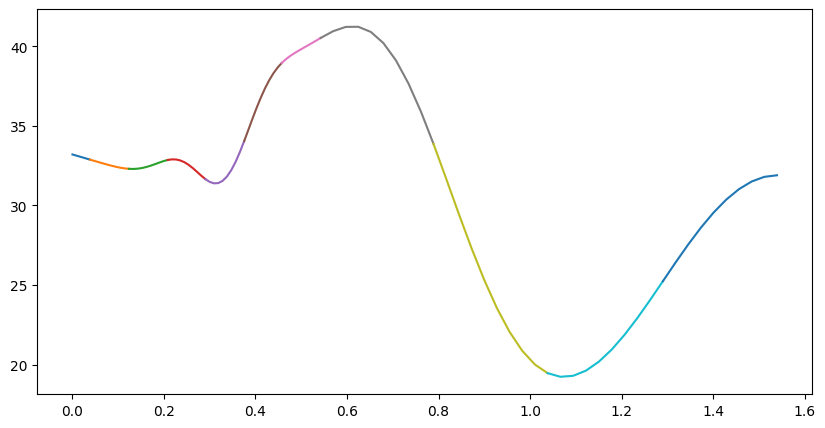

In [25]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

# Plot the polynomials
plt.figure(figsize=(10, 5))

for i, coef in enumerate(X):
    x = np.linspace(knots[i],knots[i+1], 10)
    z = X[i]
    z = z[::-1] # Reverse the polynomial coefficients to comply with numpy polynomial function
    p = Polynomial(z)
    integrate = p.integ()
    integral = (integrate(knots[i+1])- integrate(knots[i]) ) / (knots[i+1] - knots[i])
    #print(integral)
    y = p(x)
    plt.plot(x,y, label = 'Splines')

In [27]:
start = knots[1]
end = knots[2]
builder.calc_price(X, knots, start, end)


32.55000000000278